In [1]:
import glob
import rasterio
from pathlib import Path
import os
import reverse_geocoder as rg
import pyproj
import geopandas as gpd
import sys

if Path.cwd().name != 'src':
    os.chdir('/home/vaschetti/maxarSrc/src')

Print all the events' name

In [2]:
from my_functions.assemble import names
events_names = names.get_all_events()
for i, e_n in enumerate(events_names):
    print(i, e_n)

0 southafrica-flooding22
1 Kalehe-DRC-Flooding-5-8-23
2 shovi-georgia-landslide-8Aug23
3 Emilia-Romagna-Italy-flooding-may23
4 NWT-Canada-Aug-23
5 Libya-Floods-Sept-2023
6 Gambia-flooding-8-11-2022
7 New-Zealand-Flooding23
8 Hurricane-Fiona-9-19-2022
9 Hurricane-Idalia-Florida-Aug23
10 Hurricane-Ian-9-26-2022
11 yellowstone-flooding22
12 pakistan-flooding22
13 Morocco-Earthquake-Sept-2023
14 Indonesia-Earthquake22
15 cyclone-emnati22
16 Kahramanmaras-turkey-earthquake-23
17 Marshall-Fire-21-Update
18 India-Floods-Oct-2023
19 Maui-Hawaii-fires-Aug-23
20 tonga-volcano21
21 BayofBengal-Cyclone-Mocha-May-23
22 Sudan-flooding-8-22-2022


**Set some parameters** used in the segmentation phase, such as batch size and device. </br>
Also it instantiate both the **GroundingDino** model and the **Efficent SAM** model  

In [3]:
from my_functions.configs import SegmentConfig
batch_size = 2
config = SegmentConfig(batch_size = batch_size, device='cuda')

/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
- GD model device: cuda:0
- Efficient SAM device: cuda:0


Build an Event (e.g. 'Gambia-flooding-8-11-2022')</br>
Print its region and the names of its mosaics</br>
Print the number of tiles contained in the first mosaic


In [4]:
from my_functions.assemble import holders

evento = holders.Event(events_names[6], seg_config = config, when='pre')
print(evento.region_name)

all_mosaics_names = evento.all_mosaics_names
print(all_mosaics_names)

m0 = evento.mosaics[all_mosaics_names[0]]
print(f'Number of tiles: {m0.tiles_num}')


AfricaWest-Full
['10300100CFC9A500', '105001002BD68F00', '1040010073D77D00']
Number of tiles: 18


Set the geodataframe of the **building** of the first mosaic

In [5]:
m0.set_build_gdf()

Found 3 links matching: [33303200, 3330320, 333032]


Create the geodataframe of the **roads** of the first mosaic...

In [6]:
m0.set_road_gdf()

not USA. Region name: AfricaWest-Full.tsv


...and project it in the right coord system

In [7]:
m0.proj_road_gdf

,country,geometry
158659,GMB,"LINESTRING (317880.927 1483236.891, 317881.884..."
158664,GMB,"LINESTRING (317732.453 1489568.084, 317792.204..."
158669,GMB,"LINESTRING (316249.801 1478543.584, 316213.663..."
158689,GMB,"LINESTRING (317326.052 1486717.098, 317338.950..."
158694,GMB,"LINESTRING (317846.778 1481976.223, 317849.189..."
...,...,...
504425,GMB,"LINESTRING (316329.842 1477672.263, 316261.217..."
504460,GMB,"LINESTRING (316419.470 1482442.080, 316398.261..."
504480,GMB,"LINESTRING (320392.218 1489136.742, 320505.915..."
504485,GMB,"LINESTRING (316436.428 1478302.096, 316568.703..."


In [8]:
m0.tiles_paths[17]

PosixPath('/mnt/data2/vaschetti_data/maxar/Gambia-flooding-8-11-2022/pre/10300100CFC9A500/033133031233.tif')

In [9]:
from torchgeo.datasets import stack_samples, unbind_samples
from torch.utils.data import DataLoader
from rasterio.windows import Window
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from time import time
import warnings
import rasterio
import torch

from my_functions.samplers import samplers, samplers_utils
from my_functions.geo_datasets import geoDatasets
from my_functions.ESAM_segment import segment, segment_utils
from my_functions.detect import detect


# Ignore all warnings
warnings.filterwarnings('ignore')

In [ ]:
#Top, working

self = m0
tile_path = m0.tiles_paths[17]

seg_config = self.event.seg_config
dataset = geoDatasets.Maxar(str(tile_path))
sampler = samplers.MyBatchGridGeoSampler(dataset, batch_size=seg_config.batch_size, size=seg_config.size, stride=seg_config.stride)
dataloader = DataLoader(dataset , batch_sampler=sampler, collate_fn=stack_samples)

canvas = np.zeros((seg_config.size, seg_config.size, 3), dtype=np.uint8)
i = 0
f_i = 2
for batch in tqdm(dataloader):
    i+=1
    """if i != f_i:
        i+=1
        continue"""
    original_img_tsr = batch['image']
    img_b = batch['image'].permute(0,2,3,1).numpy().astype('uint8') #TODO: l'immagine viene convertita in numpy ma magari è meglio lasciarla in tensor
    
    #get the tree boxes in batches and the number of trees for each image
    tree_boxes_b, num_trees4img = detect.get_GD_boxes(img_b, seg_config.GD_model,
                                        seg_config.TEXT_PROMPT,
                                        seg_config.BOX_THRESHOLD,
                                        seg_config.TEXT_THRESHOLD,
                                        dataset.res,
                                        device = seg_config.device,
                                        max_area_mt2 = seg_config.max_area_GD_boxes_mt2)
    
    #get the building boxes in batches and the number of buildings for each image
    building_boxes_b, num_build4img = detect.get_batch_buildings_boxes(batch['bbox'],
                                                                proj_buildings_gdf = self.proj_build_gdf,
                                                                dataset_res = dataset.res,
                                                                ext_mt = 10)
    max_detect = max(num_trees4img + num_build4img)
    print("\n__________________________")
    print("Batch number: ", i)
    print(f'Num detections in batch: {num_trees4img + num_build4img}')
    
    #obtain the right input for the ESAM model (trees + buildings)
    input_points, input_labels = segment_utils.get_input_pts_and_lbs(tree_boxes_b, building_boxes_b, max_detect)
    
    # segment the image and get for each image as many masks as the number of boxes,
    # for GPU constraint use num_parall_queries
    all_masks_b = segment.ESAM_from_inputs(original_img_tsr,
                                            torch.from_numpy(input_points),
                                            torch.from_numpy(input_labels),
                                            efficient_sam = seg_config.efficient_sam,
                                            device = seg_config.device,
                                            num_parall_queries = 5)
    
    #for each image, discern the masks in trees, buildings and padding
    tree_mask_b, building_mask_b, pad_mask_b = segment_utils.discern(all_masks_b, num_trees4img, num_build4img)
    
    if i == f_i:
        break

  0%|          | 0/1682 [00:00<?, ?it/s]

In sampler
tile_polygon:  POLYGON ((315427.24609375 1485156.25, 320156.25 1485156.25, 320156.25 1479843.75, 315394.8974609375 1479843.75, 315427.24609375 1485156.25))

__________________________
Batch number:  1
Num detections in batch: [ 51 102]


  0%|          | 1/1682 [00:06<3:04:08,  6.57s/it]


__________________________
Batch number:  2
Num detections in batch: [78 45]


  0%|          | 1/1682 [00:08<3:54:54,  8.38s/it]


In [ ]:
from my_functions import plotting_utils as plu

ix = 1
plu.plot_comparison(img_b[ix], np.stack((tree_mask_b[ix], building_mask_b[ix])))

In [12]:
def write_canvas(canvas: np.array,
                 patch_masks_b: np.array,
                 img_ixs: np.array,
                 stride: int,
                 total_cols: int):
    """
    Write the patmasks in the canvas
    Inputs:
        canvas: np.array of shape (channel, h_tile, w_tile)
        patch_masks_b: np.array of shape (b, channel, h_patch, w_patch)
        img_ixs: np.array of shape (b,)
    """
    size = patch_masks_b.shape[-1]
    #print("img_ixs", img_ixs)
    for img_ix, patch_mask in zip(img_ixs, patch_masks_b):
        rows_changed = img_ix // total_cols
        cols_changed = img_ix % total_cols
        inv_base = (canvas.shape[1] - 1 - size) - (stride * rows_changed)
        base = (stride * cols_changed)
        canva_writable_space = canvas[:, inv_base: inv_base + size, base: base + size].shape[1:] #useful when reached the border of the canva
        print('\nparte di canva', canvas[:, inv_base: inv_base + size, base: base + size].shape)
        print('patch', patch_mask[:, :canva_writable_space[0], :canva_writable_space[1]].shape)
        canvas[:, inv_base: inv_base + size, base: base + size] = patch_mask[:, :canva_writable_space[0], :canva_writable_space[1]]

    return canvas

In [13]:
def segment_tile(self, tile_path):
    seg_config = self.event.seg_config

    dataset = geoDatasets.MxrSingleTile(str(tile_path))
    sampler = samplers.WholeTifGridGeoSampler(dataset, batch_size=seg_config.batch_size, size=seg_config.size, stride=seg_config.stride)
    dataloader = DataLoader(dataset , batch_sampler=sampler, collate_fn=stack_samples)

    canvas = np.zeros((3,) + samplers_utils.tile_sizes(dataset), dtype=np.uint8) #dim (3, h_tile, w_tile). The first dim is tree, build, pad
    
    all_batches_img_ixs = np.arange(len(sampler)).reshape((-1, batch_size))
    _, total_cols = sampler.get_num_rows_cols()
    
    i = 0
    f_i = 50
    start_time_all = time()
    for batch_ix, batch in tqdm(enumerate(dataloader), total = len(dataloader)):
        i+=1
        original_img_tsr = batch['image']
        img_b = batch['image'].permute(0,2,3,1).numpy().astype('uint8') #TODO: l'immagine viene convertita in numpy ma magari è meglio lasciarla in tensor

        #trees
        GD_t_0 = time()
        
        #get the tree boxes in batches and the number of trees for each image
        tree_boxes_b, num_trees4img = detect.get_GD_boxes(img_b,
                                            seg_config.GD_model,
                                            seg_config.TEXT_PROMPT,
                                            seg_config.BOX_THRESHOLD,
                                            seg_config.TEXT_THRESHOLD,
                                            dataset.res,
                                            device = seg_config.device,
                                            max_area_mt2 = seg_config.max_area_GD_boxes_mt2)
        #tree_boxes_b è una lista con degli array di shape (n, 4) dove n è il numero di tree boxes
        
        #print('GD_time: ', time() - GD_t_0)

        #get the building boxes in batches and the number of buildings for each image
        building_boxes_b, num_build4img = detect.get_batch_buildings_boxes(batch['bbox'],
                                                                    proj_buildings_gdf = self.proj_build_gdf,
                                                                    dataset_res = dataset.res,
                                                                    ext_mt = 10)
        
        #building_boxes_b è una lista con degli array di shape (n, 4) dove n è il numero di building boxes
        
        max_detect = max(num_trees4img + num_build4img)
        
        #print("\n__________________________")
        #print("Batch number: ", i)
        #print(f'Num detections in batch per img: {num_trees4img + num_build4img}')
        
        #obtain the right input for the ESAM model (trees + buildings)
        input_points, input_labels = segment_utils.get_input_pts_and_lbs(tree_boxes_b, building_boxes_b, max_detect)
        
        # segment the image and get for each image as many masks as the number of boxes,
        # for GPU constraint use num_parall_queries
        all_masks_b = segment.ESAM_from_inputs(original_img_tsr,
                                                torch.from_numpy(input_points),
                                                torch.from_numpy(input_labels),
                                                efficient_sam = seg_config.efficient_sam,
                                                device = seg_config.device,
                                                num_parall_queries = 5)
        
        
        #for each image, discern the masks in trees, buildings and padding
        patch_masks_b = segment_utils.discern_mode(all_masks_b, num_trees4img, num_build4img, mode = 'bchw')
        
        canvas = write_canvas(canvas = canvas,
                                            patch_masks_b =  patch_masks_b,
                                            img_ixs = all_batches_img_ixs[batch_ix],
                                            stride = seg_config.stride,
                                            total_cols = total_cols)
        
        if i == f_i:
            break
        
    #print(f'\nTotal Time for {seg_config.batch_size * i} images: ', time() - start_time_all)
    return canvas

canvas = segment_tile(m0, m0.tiles_paths[17])
#img_b, original_img, tree_boxes_b, building_boxes_b, all_masks_b, tree_mask_b, building_mask_b, pad_mask_b = segment_tile(m0, m0.tiles_paths[17])

  0%|          | 0/1682 [00:00<?, ?it/s]

In sampler
tile_polygon:  POLYGON ((315427.24609375 1485156.25, 320156.25 1485156.25, 320156.25 1479843.75, 315394.8974609375 1479843.75, 315427.24609375 1485156.25))


  0%|          | 1/1682 [00:00<15:44,  1.78it/s]

GD_time:  0.5186784267425537

__________________________
Batch number:  1
Num detections in batch per img: [0 0]

parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)


  0%|          | 2/1682 [00:01<16:28,  1.70it/s]

GD_time:  0.5701959133148193

__________________________
Batch number:  2
Num detections in batch per img: [0 0]

parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.5595622062683105

__________________________
Batch number:  3
Num detections in batch per img: [ 6 51]


  0%|          | 3/1682 [00:02<28:01,  1.00s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.488964319229126

__________________________
Batch number:  4
Num detections in batch per img: [102  78]


  0%|          | 4/1682 [00:05<44:16,  1.58s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.4842491149902344

__________________________
Batch number:  5
Num detections in batch per img: [45 29]


  0%|          | 5/1682 [00:06<41:15,  1.48s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.48392653465270996

__________________________
Batch number:  6
Num detections in batch per img: [54 78]


  0%|          | 6/1682 [00:08<44:48,  1.60s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.48981475830078125

__________________________
Batch number:  7
Num detections in batch per img: [90 83]


  0%|          | 7/1682 [00:10<51:08,  1.83s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.4922783374786377

__________________________
Batch number:  8
Num detections in batch per img: [78 73]


  0%|          | 8/1682 [00:12<51:26,  1.84s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.48270153999328613

__________________________
Batch number:  9
Num detections in batch per img: [81 67]


  1%|          | 9/1682 [00:14<54:23,  1.95s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.5176615715026855

__________________________
Batch number:  10
Num detections in batch per img: [32 22]


  1%|          | 10/1682 [00:15<47:07,  1.69s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.4971582889556885

__________________________
Batch number:  11
Num detections in batch per img: [37 60]


  1%|          | 11/1682 [00:17<45:37,  1.64s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.48652124404907227

__________________________
Batch number:  12
Num detections in batch per img: [64 76]


  1%|          | 12/1682 [00:19<48:38,  1.75s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.48552989959716797

__________________________
Batch number:  13
Num detections in batch per img: [ 97 119]


  1%|          | 13/1682 [00:22<58:37,  2.11s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.4897136688232422

__________________________
Batch number:  14
Num detections in batch per img: [111 104]


  1%|          | 14/1682 [00:24<1:04:15,  2.31s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.48824167251586914

__________________________
Batch number:  15
Num detections in batch per img: [119 144]


  1%|          | 15/1682 [00:28<1:16:12,  2.74s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.48972296714782715

__________________________
Batch number:  16
Num detections in batch per img: [146 152]


  1%|          | 16/1682 [00:32<1:27:39,  3.16s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.490833044052124

__________________________
Batch number:  17
Num detections in batch per img: [162 132]


  1%|          | 17/1682 [00:37<1:39:07,  3.57s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.4985954761505127

__________________________
Batch number:  18
Num detections in batch per img: [126 168]


  1%|          | 18/1682 [00:42<1:48:18,  3.91s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.4842205047607422

__________________________
Batch number:  19
Num detections in batch per img: [177 134]


  1%|          | 19/1682 [00:46<1:56:51,  4.22s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.48509645462036133

__________________________
Batch number:  20
Num detections in batch per img: [141 113]


  1%|          | 20/1682 [00:50<1:53:32,  4.10s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.4893667697906494

__________________________
Batch number:  21
Num detections in batch per img: [121 130]


  1%|          | 21/1682 [00:54<1:47:15,  3.87s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.49751949310302734

__________________________
Batch number:  22
Num detections in batch per img: [105  77]


  1%|▏         | 22/1682 [00:56<1:36:54,  3.50s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.48704004287719727

__________________________
Batch number:  23
Num detections in batch per img: [83 60]


  1%|▏         | 23/1682 [00:58<1:24:53,  3.07s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.4972820281982422

__________________________
Batch number:  24
Num detections in batch per img: [48 72]


  1%|▏         | 24/1682 [01:00<1:14:36,  2.70s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.5061535835266113

__________________________
Batch number:  25
Num detections in batch per img: [112 127]


  1%|▏         | 25/1682 [01:04<1:19:58,  2.90s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.4856555461883545

__________________________
Batch number:  26
Num detections in batch per img: [145 169]


  2%|▏         | 26/1682 [01:08<1:35:14,  3.45s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.48273801803588867

__________________________
Batch number:  27
Num detections in batch per img: [152 156]


  2%|▏         | 27/1682 [01:13<1:41:42,  3.69s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.481931209564209

__________________________
Batch number:  28
Num detections in batch per img: [142 119]


  2%|▏         | 28/1682 [01:16<1:42:26,  3.72s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.5005137920379639

__________________________
Batch number:  29
Num detections in batch per img: [100  55]


  2%|▏         | 29/1682 [01:19<1:32:11,  3.35s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 308)
patch (3, 600, 308)


  2%|▏         | 30/1682 [01:19<1:08:46,  2.50s/it]

GD_time:  0.49041032791137695

__________________________
Batch number:  30
Num detections in batch per img: [0 0]

parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)


  2%|▏         | 31/1682 [01:20<53:07,  1.93s/it]  

GD_time:  0.5890471935272217

__________________________
Batch number:  31
Num detections in batch per img: [0 0]

parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.5934374332427979

__________________________
Batch number:  32
Num detections in batch per img: [ 6 43]


  2%|▏         | 32/1682 [01:21<48:03,  1.75s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.4880220890045166

__________________________
Batch number:  33
Num detections in batch per img: [86 80]


  2%|▏         | 33/1682 [01:23<51:57,  1.89s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.48785996437072754

__________________________
Batch number:  34
Num detections in batch per img: [52 45]


  2%|▏         | 34/1682 [01:25<47:49,  1.74s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.48991918563842773

__________________________
Batch number:  35
Num detections in batch per img: [70 88]


  2%|▏         | 35/1682 [01:27<51:32,  1.88s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.5104312896728516

__________________________
Batch number:  36
Num detections in batch per img: [84 63]


  2%|▏         | 36/1682 [01:29<53:14,  1.94s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.4903564453125

__________________________
Batch number:  37
Num detections in batch per img: [54 58]


  2%|▏         | 37/1682 [01:31<49:39,  1.81s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.4880964756011963

__________________________
Batch number:  38
Num detections in batch per img: [66 63]


  2%|▏         | 38/1682 [01:32<48:46,  1.78s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.49414515495300293

__________________________
Batch number:  39
Num detections in batch per img: [20  1]


  2%|▏         | 39/1682 [01:33<41:41,  1.52s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.5052666664123535

__________________________
Batch number:  40
Num detections in batch per img: [15 58]


  2%|▏         | 40/1682 [01:35<42:10,  1.54s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.4941251277923584

__________________________
Batch number:  41
Num detections in batch per img: [69 57]


  2%|▏         | 41/1682 [01:37<43:33,  1.59s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.4863715171813965

__________________________
Batch number:  42
Num detections in batch per img: [ 73 108]


  2%|▏         | 42/1682 [01:39<52:45,  1.93s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.4922828674316406

__________________________
Batch number:  43
Num detections in batch per img: [98 84]


  3%|▎         | 43/1682 [01:42<56:49,  2.08s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.5114972591400146

__________________________
Batch number:  44
Num detections in batch per img: [97 96]


  3%|▎         | 44/1682 [01:44<59:51,  2.19s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.4983181953430176

__________________________
Batch number:  45
Num detections in batch per img: [105 127]


  3%|▎         | 45/1682 [01:47<1:08:52,  2.52s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.5000081062316895

__________________________
Batch number:  46
Num detections in batch per img: [139 143]


  3%|▎         | 46/1682 [01:51<1:19:19,  2.91s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.5055358409881592

__________________________
Batch number:  47
Num detections in batch per img: [133 139]


  3%|▎         | 47/1682 [01:55<1:24:52,  3.11s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.48621392250061035

__________________________
Batch number:  48
Num detections in batch per img: [131 130]


  3%|▎         | 48/1682 [01:58<1:27:25,  3.21s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.4966580867767334

__________________________
Batch number:  49
Num detections in batch per img: [140 120]


  3%|▎         | 49/1682 [02:02<1:30:39,  3.33s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)
GD_time:  0.4962198734283447

__________________________
Batch number:  50
Num detections in batch per img: [140 142]


  3%|▎         | 49/1682 [02:06<1:10:06,  2.58s/it]


parte di canva (3, 600, 600)
patch (3, 600, 600)

parte di canva (3, 600, 600)
patch (3, 600, 600)

Total Time for 100 images:  126.22936868667603


In [14]:
np.unique(canvas)

array([0, 1], dtype=uint8)

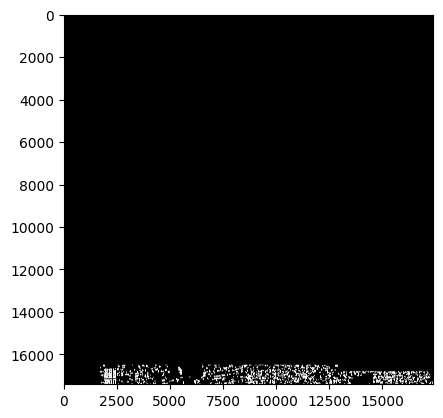

In [19]:
import matplotlib.pyplot as plt

# Visualize the array
plt.imshow(canvas[1], cmap='gray')
plt.show()

In [ ]:
-np.ones((2,3))

array([[-1., -1., -1.],
       [-1., -1., -1.]])

Trying a new geodataset

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
tile_path = Path('/mnt/data2/vaschetti_data/maxar/Gambia-flooding-8-11-2022/pre/10300100CFC9A500/033133031233.tif')

In [ ]:
dataset = geoDatasets.MxrSingleTile(str(tile_path))
sampler = samplers.WholeTifGridGeoSampler(dataset, batch_size=1, size= 1000, stride=1000)
dataloader = DataLoader(dataset , batch_sampler=sampler, collate_fn=stack_samples)

In [ ]:
samplers_utils.tile_sizes(dataset)

(17408, 17408)

In [ ]:
sampler.get_rows_cols()

(18, 18)

In [ ]:
canvas = np.zeros(samplers_utils.tile_sizes(dataset) +  (3,) , dtype=np.uint8)

In [ ]:
canvas.shape

(17408, 17408, 3)

In [ ]:
batch_size=4
np.arange(len(sampler)).reshape((-1, batch_size))

In [ ]:
batch_size=3
batch_ix = 8
img_ixs = np.arange(len(sampler)).reshape((-1, batch_size))[batch_ix]
img_ixs

array([24, 25, 26])

In [ ]:
rows, cols = sampler.get_rows_cols()
img_ix = 20
rows_changed = img_ix // cols
cols_changed = img_ix % cols
rows_changed, cols_changed

(1, 2)

In [ ]:
size = 1000
stride = 1000
batch_size = 4
rows, cols = sampler.get_rows_cols()

canvas = np.zeros(samplers_utils.tile_sizes(dataset) +  (2,) , dtype=np.uint8)

inv_base = (canvas.shape[0] - 1) - size #dim 0, top left corner of the first patch
base = 0 #dim 1, top left corner of the first patch

batch_ix = 0
img_ixs = np.arange(len(sampler)).reshape((-1, batch_size))[batch_ix]
#img_ix = img_ixs[0]
img_ix = 18
print(f'{img_ix = }')

rows_changed = img_ix // cols
cols_changed = img_ix % cols
print(f'row, cols changed {rows_changed, cols_changed}')

base = (stride * cols_changed)
print(f'{base = }')

inv_base = (canvas.shape[0] - 1 - size) - (stride * rows_changed)
print(f'{(canvas.shape[0]-1)-inv_base}')

print((inv_base, inv_base + size) , (base, base + size))


img_ix = 18
row, cols changed (1, 0)
base = 0
2000
(15407, 16407) (0, 1000)


In [ ]:
res = np.ones((2, 5, 5), dtype=np.uint8)
res[:, 3,2] = 7
res

array([[[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 7, 1, 1],
        [1, 1, 1, 1, 1]],

       [[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 7, 1, 1],
        [1, 1, 1, 1, 1]]], dtype=uint8)

In [ ]:
inv_base = canvas.shape[0]-1
base = 0 
size= 1000
#deve tutto basarsi sull'indice di batch e batch size
batch_size=4
batch_ix = 0
img_ixs = np.arange(len(sampler)).reshape((-1, batch_size))[batch_ix]
#ora tutto deve basarsi su img_ixs


#cambia 
#cambia riga ogni volta che aumente il numero

#ogni volta che cambia riga inv_base -=  size
#ogni volta che cambia colonna base += size, quando arrivo a fine riga deve resettarsi
canvas[inv_base-size : inv_base,
       base: base+size,
       0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
patch_counter = 0
x_ = 0
y_pxl = 0

for i, batch in enumerate(dataloader):
    if i%18 == 0:
        x_pxl = 0
        y_pxl += 1000
    
    x_pxl += 1000
    print(i)
    i+=1

In [ ]:
for i, batch in enumerate(dataloader):
    if i%30 != 0:
        continue
    image_tensor = batch['image'][0]
    image = image_tensor.permute(1, 2, 0).numpy().astype('uint8')
    
    plt.imshow(image)
    plt.show()
    

In [ ]:
dataset = geoDatasets.MxrSingleTile(str(tile_path))
sampler = samplers.MyBatchGridGeoSampler(dataset, batch_size=1, size= 1000, stride=1000)
dataloader = DataLoader(dataset , batch_sampler=sampler, collate_fn=stack_samples)

In [ ]:
i=0
for i, batch in enumerate(dataloader):
    if i%30 != 0:
        continue
    image_tensor = batch['image'][0]
    image = image_tensor.permute(1, 2, 0).numpy().astype('uint8')
    
    plt.imshow(image)
    plt.show()

In [ ]:
len(sampler)

In [ ]:
element = next(iter(dataloader))

In [ ]:
image_tensor = element['image'][15]
image = image_tensor.permute(1, 2, 0).numpy().astype('uint8')

plt.imshow(image)
plt.show()

# End of useful code

In [ ]:
np_final_mask = np.greater_equal(all_masks_b, 0).any(axis=1)
np_final_mask.shape

In [ ]:
from my_functions.plotting_utils import show_mask
import matplotlib.patches as patches
    
def plot_w_wo_masks_ESAM(img, masks, building_boxes = None, rgb_colors = [[117, 255, 61], [164, 99, 214], [80, 137, 199]] , random_color = False):
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img)

    ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
    ax2.imshow(img)
    if masks.ndim == 2:
        masks = masks[np.newaxis, ...]
    for i, mask in enumerate(masks):
        show_mask(mask, ax2, rgb_color=rgb_colors[i] , random_color = random_color)
    if building_boxes is not None:
        for box in building_boxes:
            x0, y0 = box[0], box[1]
            w, h = box[2] - box[0], box[3] - box[1]
            rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')            
            ax2.add_patch(rect)
    
    ax2.set_xlim([0, img.shape[1]])
    ax2.set_ylim([img.shape[0], 0])

    ax1.axis('off')
    ax2.axis('off')

In [ ]:
ix = 3
plot_w_wo_masks_ESAM(img_b[ix], pad_mask_b[ix])

In [ ]:
ix = 3
plot_w_wo_masks_ESAM(img_b[ix], building_mask_b[ix])

In [ ]:
ix = 9
all_mask_no_overlap = segment.rmv_mask_overlap(np.stack((tree_mask_b[ix], building_mask_b[ix])))
plot_w_wo_masks_ESAM(img_b[ix], all_mask_no_overlap)

In [ ]:
mask_b_no_overlap = segment.rmv_mask_b_overlap(np.stack((tree_mask_b, building_mask_b), axis=1))

In [ ]:
ix = 9
plot_w_wo_masks_ESAM(img_b[ix], mask_b_no_overlap[ix])

In [ ]:
ix = 1
plot_w_wo_masks_ESAM(img_b[ix], np.stack((tree_mask_b[ix], building_mask_b[ix])), random_color=True)

In [ ]:
def rmv_mask_overlap(overlapping_masks: np.array):
    disjoined_masks = np.copy(overlapping_masks)
    for i in range(overlapping_masks.shape[0] - 1):
        sum_mask = np.sum(overlapping_masks[i:], axis=0)
        disjoined_masks[i] = np.where(sum_mask > 1, False, overlapping_masks[i])

    return disjoined_masks

rmv_mask_overlap(all)

In [ ]:
def rmv_mask_overlap(overlapping_masks: np.array):
    for i in range(overlapping_masks.shape[0] - 1, 0, -1):
        sum_mask = overlapping_masks[i-1] + overlapping_masks[i]
        overlapping_masks[i]

        print(i)

    #return disjoined_masks

rmv_mask_overlap(all)

In [ ]:
original_img.shape

In [ ]:
from torchvision import transforms
single_img_np = img_b[0]
print(single_img_np.shape)
a  = transforms.ToTensor()(single_img_np)
single_img_tsr = original_img[0]
b = single_img_tsr.div(255)
torch.equal(a, b)

In [ ]:
torch.equal(original_img.div(255)[0], b)

In [ ]:
single_img_np.shape

In [ ]:
single_img_tsr = original_img[0]
single_img_tsr.div(255)

In [ ]:
import torch
torch.from_numpy(single_img_np.transpose((2, 0, 1))).contiguous()


In [ ]:
from torchvision import transforms
transforms.ToTensor()(original_img)

In [ ]:
import rasterio

with rasterio.open('/mnt/data2/vaschetti_data/maxar/Indonesia-Earthquake22/post/10300100DD6AE200/300020121231.tif') as src:
    print(src.profile)
    print(src.transform * (0,0))
    print(type(src.read()))

In [ ]:
import torch
torch.tensor([torch.tensor([1,23]), torch.tensor([1,23])])

In [ ]:
a = np.array([[2,3,5,6]]*5)
print('a', a.shape)
b = np.expand_dims(a, 0)
print('b', b.shape)
b.reshape(-1,2,2).shape
lbs = np.array([[2,3]]*a.shape[0]) #(query_img_x, 2)
print('lbs', lbs.shape)

lbs_pad_value = 0
pad_len = 3
pad_width = ((0,pad_len),(0, 0))
padded_lbs = np.pad(lbs, pad_width, constant_values = lbs_pad_value)
print('padded_lbs', padded_lbs.shape)

#

#np.expand_dims(np.array([[2,3]]*89), 0).reshape(-1,2,2).shape

In [ ]:
max_detect = 0
for tree_detec, build_detec in zip(tree_boxes_b, building_boxes_b):
    tree_build_detect = np.concatenate((tree_detec, build_detec))
    print(tree_build_detect.shape)
    if tree_build_detect.shape[0] > max_detect:
        max_detect = tree_build_detect.shape[0]
print(max_detect)

In [ ]:
tree_build_detect[-2:]

In [ ]:
boxes4FSam[9][-2:]

In [ ]:
tree_boxes_b.shape

In [ ]:
building_boxes_b[0]

In [ ]:

#pad_len = max_detect - building_boxes_b[0].shape[0]
pad_len = 4
pad_width = ((0,pad_len),(0, 0))
np.pad(building_boxes_b[0], pad_width, constant_values=0)

In [ ]:
a = np.array([[1,2,3],[4,5,6]])
b = [a]
np.array(b)

In [ ]:
pad_width = ((0,1),(0, 0))
pad_width = (1,1)
pad_value = (1,2)
np.pad(a, pad_width, constant_values = pad_value)

In [ ]:
pad_width = (0, 2)
pad_value = [0,0,0,0]
np.pad(building_boxes_b[0], pad_width, constant_values=pad_value)

In [ ]:
a = np.array([1,2,3])
b = np.array([4,5,6])
np.concatenate((a,b))
a+b

In [ ]:
tree_boxes_b[0]

In [ ]:
building_boxes_b[0]

In [ ]:
from my_functions.plotting_utils import show_mask, show_Linestrings, show_points, show_box, plot_comparison
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ix = 8
ax.imshow(img_b[ix])
#show_box(tree_boxes_b[ix].tolist(), ax, color='b')
show_box(building_boxes_b[ix], ax, color='r')
plt.show()

In [ ]:
from my_functions.plotting_utils import show_mask, show_Linestrings, show_points, show_box, plot_comparison
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ix = 9
ax.imshow(img_b[ix])
show_box(tree_boxes_b[ix].tolist(), ax, color='b')

In [ ]:
import rasterio
from rasterio.windows import Window
from my_functions import geoDatasets
from my_functions.samplers import MyGridGeoSampler, MyBatchGridGeoSampler
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, unbind_samples
import matplotlib.pyplot as plt
from tqdm import tqdm

def segment_tile(self, tile_path):
    batch_size = 4
    dataset = geoDatasets.Maxar(str(tile_path))
    sampler = MyBatchGridGeoSampler(dataset, batch_size=batch_size, size=100, stride=100)
    print(len(sampler))
    dataloader = DataLoader(dataset , batch_sampler=sampler, collate_fn=stack_samples)
    print(len(dataloader))
    print(dataset.res)
    for batch in tqdm(dataloader):
        #print(batch.keys())
        #samples_list = unbind_samples(batch)
        #print(samples_list)
        #img_batch = batch['image']
        #print(type(img_batch))
        
        #Le immagini sono già RGB
        img_b = batch['image'].permute(0,2,3,1).numpy().astype('uint8')
        #fig, axs = plt.subplots(1, batch_size, figsize=(30, 30))
        #for i in range(batch_size):
        #    axs[i].imshow(img_b[i])
        #print(img_b.shape)
        break
    return img_b

img_b = segment_tile(evento, m0.tiles_paths[0])

In [ ]:
m0.dataset_res

In [ ]:
img_b.shape

In [ ]:
import numpy as np
from my_functions import segment
from groundingdino.util.inference import predict as GD_predict
from groundingdino.util.inference import load_model as GD_load_model

def get_gdino_boxes(img_batch: np.array,
                    GDINO_model,
                    TEXT_PROMPT,
                    BOX_TRESHOLD,
                    TEXT_TRESHOLD,
                    dataset_res,
                    max_area_mt2 =3000):
    all_tree_boxes4Sam = []
    for img in img_batch:
        image_transformed = segment.dino_img_load(img)
        tree_boxes, logits, phrases = GD_predict(GDINO_model, image_transformed, TEXT_PROMPT, BOX_TRESHOLD, TEXT_TRESHOLD)
        tree_boxes4Sam = []
        if len(tree_boxes) != 0:
            sample_size = image_transformed.shape[-1]
            keep_ix_tree_boxes = segment.filter_on_box_area_mt2(tree_boxes, sample_size, dataset_res, max_area_mt2 = max_area_mt2)
            tree_boxes4Sam = segment.GDboxes2SamBoxes(tree_boxes[keep_ix_tree_boxes], sample_size)
            all_tree_boxes4Sam.append(tree_boxes4Sam)
    return all_tree_boxes4Sam

In [ ]:
GDINO_root ="/home/vaschetti/maxarSrc/models/GDINO"
CONFIG_PATH = os.path.join(GDINO_root, "GroundingDINO_SwinT_OGC.py")
WEIGHTS_PATH = os.path.join(GDINO_root, "groundingdino_swint_ogc.pth")
GDINO_model = GD_load_model(CONFIG_PATH, WEIGHTS_PATH, device = 'cuda')
TEXT_PROMPT = 'green tree' #'house' or 'tree' or 'green tree'
BOX_TRESHOLD = 0.15
TEXT_TRESHOLD = 0.30

In [ ]:
dataset_res = 0.30517578125
get_gdino_boxes(img_b, GDINO_model, TEXT_PROMPT, BOX_TRESHOLD, TEXT_TRESHOLD, dataset_res)

In [ ]:
import groundingdino.datasets.transforms as T
import numpy as np
import torch
from PIL import Image

def batch_GD_img_load(batch_np_img_rgb: np.array)-> torch.Tensor:
    """
    Transform the image from np.array to torch.Tensor and normalize it.
    """
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    for i, np_img_rgb in enumerate(batch_np_img_rgb):
        image_pillow = Image.fromarray(np_img_rgb)
        image_transformed, _ = transform(image_pillow, None)
        if i == 0:
            batch_images_transformed = image_transformed.unsqueeze(0)
        else:
            batch_images_transformed = torch.cat((batch_images_transformed, image_transformed.unsqueeze(0)), dim=0)
    return batch_images_transformed

def dino_img_load(np_img_rgb: np.array)-> torch.Tensor:
    """
    Transform the image from np.array to torch.Tensor and normalize it.
    """
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image_pillow = Image.fromarray(np_img_rgb)
    image_transformed, _ = transform(image_pillow, None)
    return image_transformed

def load_image(image_path):
    # load image
    image_pil = Image.open(image_path).convert("RGB")  # load image
    print(image_pil.getbands())

    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image, _ = transform(image_pil, None)  # 3, h, w
    return image_pil, image

In [ ]:
image, image_transformed = load_image('/home/vaschetti/maxarSrc/exampleData/10300100C2D81700-visual_small.tif')

In [ ]:
img_path = '/home/vaschetti/maxarSrc/exampleData/10300100C2D81700-visual.tif'
image_pil, image = load_image(img_path)

In [ ]:
image_pil.getbands()

In [ ]:
type(Image.open(img_path).convert("RGB"))

In [ ]:
image

In [ ]:
plt.imshow(image.permute(1,2,0).numpy().astype('uint8'))